# AI 전공 프로젝트
> ### 프로젝트 팀명 : 포토그래퍼(3조)
> ### 프로젝트 주제 : Best Photo Classification and Select Model

## Ⅰ. 개발 환경 설정

> ### 1. Import Packages

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.models import load_model
import random
import cv2
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import math
import time
## Encoding
# -*- coding: utf-8 -*-

> ### 2. Drive Mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


> ### 3. Load Data

* dataset 목록 확인 

In [ ]:
!ls -l '/content/drive/My Drive/AI_team3/dataset_final/img_final_mdx.zip'

-rw------- 1 root root 311857006 Apr 20 06:29 '/content/drive/My Drive/AI_team3/dataset_final/img_final_mdx.zip'


* Unzip Dataset

In [ ]:
!unzip /content/drive/My\Drive/AI_team3/dataset_final/img_final_mdx.zip

## Ⅱ. Data Preprocessing

> ### 1. Apply Image Generator

* dataset 경로 설정

In [ ]:
image_dir = 'img'

* Image Data Generator 설정 및 적용 (1)

    * train 80% , test 20% 분할

In [ ]:
random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 1515, class_mode = 'binary', subset='training')
test_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=10, class_mode='binary', subset='validation')

Found 1515 images belonging to 2 classes.
Found 377 images belonging to 2 classes.


*  train data - Image set and Label 분리

In [ ]:
X_train, y_train = train.next()

* Image Data Generator 설정 및 적용 (2)
    * train 80% 를 train / validation 으로 분할
    * train 60% / validation 20%

In [ ]:
datagen_second = ImageDataGenerator(validation_split=0.2)

train_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 12, subset='training')
valid_generator = datagen_second.flow(X_train, y_train , seed=random_seed, batch_size = 3, subset='validation')

*  train data / validation data 개수 확인

In [ ]:
print(len(train_generator))  ## batch size 12 로 나눈 값 출력
print(len(valid_generator))  ## batch size 3 으로 나눈 값 출력

## train data : 1212
## validation data : 303

101
101


## Ⅲ. Modeling (Transfer Learning)

> ### 1. Transfer Learning Model Load

* Model : VGG16

In [ ]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (640, 640, 3))

> ### 2. Fine Tuning Layer setting

* Tuning Layer : from block5_conv1 ~

In [ ]:
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':       
    set_trainable = True

  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

* VGG16 Model Summary

In [ ]:
conv_base.summary()

## Trainable params: 7,079,424

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 320, 128)     147584    
______________________________________________________________

> ### 3. DNN Layer Define

* 2 Hidden Layer
* Batch Nomalization and Dropout 적용
* Activation Function : Relu

In [ ]:
tf.keras.initializers.HeNormal()  ## 가중치 초기화 함수 적용

model = models.Sequential()
model.add(conv_base)   ## VGG16 Model

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(layers.Dense(256))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(1, activation = 'sigmoid'))   

model.summary()

## Total Trainable params: 112,070,657

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 20, 20, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               104858112 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

> ### 4. Model Compile

In [ ]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ### 5. Model Fitting

In [ ]:
%%time

## 소요 시간 : 55분 

Hist = model.fit(train_generator, 
                 steps_per_epoch = train_generator.n // train_generator.batch_size, 
                 epochs = 50, 
                 validation_data = valid_generator,
                 validation_steps=valid_generator.n // valid_generator.batch_size)

Epoch 1/50
101/101 [==============================] - 84s 672ms/step - loss: 0.5428 - accuracy: 0.7211 - val_loss: 0.6434 - val_accuracy: 0.6832
Epoch 2/50
101/101 [==============================] - 64s 631ms/step - loss: 0.3664 - accuracy: 0.8424 - val_loss: 0.3126 - val_accuracy: 0.8746
Epoch 3/50
101/101 [==============================] - 64s 639ms/step - loss: 0.2801 - accuracy: 0.9026 - val_loss: 0.2889 - val_accuracy: 0.8845
Epoch 4/50
101/101 [==============================] - 65s 645ms/step - loss: 0.2537 - accuracy: 0.9059 - val_loss: 0.2742 - val_accuracy: 0.8779
Epoch 5/50
101/101 [==============================] - 65s 647ms/step - loss: 0.1893 - accuracy: 0.9563 - val_loss: 0.2706 - val_accuracy: 0.8977
Epoch 6/50
101/101 [==============================] - 66s 650ms/step - loss: 0.1979 - accuracy: 0.9373 - val_loss: 0.3505 - val_accuracy: 0.8614
Epoch 7/50
101/101 [==============================] - 66s 652ms/step - loss: 0.1771 - accuracy: 0.9513 - val_loss: 0.2631 - val_ac

## Ⅳ. Model 평가

* test data 활용
* Accuracy : 0.92838
* Loss : 0.17416

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Loss : {loss:.5f}')
print(f'Accuracy : {accuracy:.5f}')

38/38 [==============================] - 39s 709ms/step - loss: 0.1742 - accuracy: 0.9284
Loss : 0.17416
Accuracy : 0.92838


* Loss and Accuracy Visualization

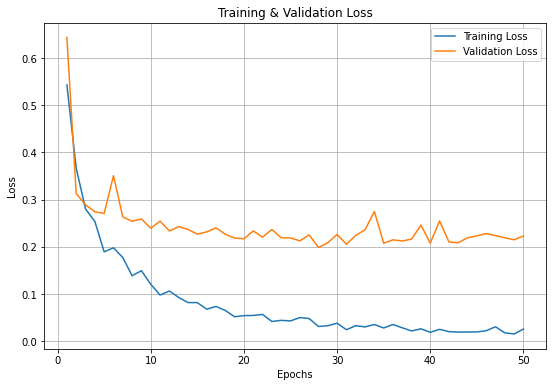

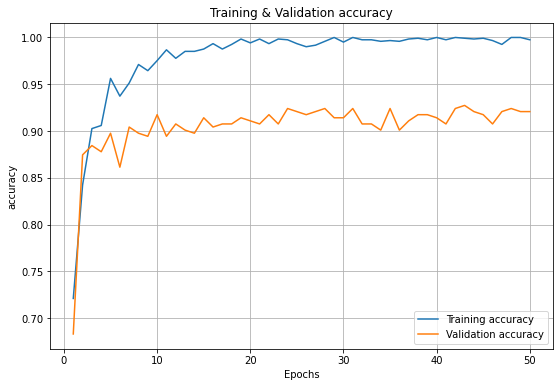

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['loss'])
plt.plot(epochs, Hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()
print()

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist.history['accuracy'])
plt.plot(epochs, Hist.history['val_accuracy'])

plt.title('Training & Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

## Ⅴ. best / worst 분류 시각화

## Ⅵ. Model Save

* 저장 경로 설정

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/VGG16_5-1_addBatchNormal&test_split_0.928.h5')  # train time : 55분

* 저장 결과 확인

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 4300119
-rw------- 1 root root      34592 Mar 17 07:49  001_model_iris.h5
-rw------- 1 root root   21346912 Mar 23 06:31  003_dogs_cats_augmentation.h5
-rw------- 1 root root   25199032 Mar 24 05:24  004_dogs_and_cats_features_extraction.h5
-rw------- 1 root root  140748416 Mar 24 07:33  005_dogs_and_cats_fine_tuning.h5
-rw------- 1 root root  201873880 Apr  1 13:27  006_dogs_and_cats_VGG16.h5
-rw------- 1 root root 2638611656 Apr 20 08:35  model_resnet.h5
-rw------- 1 root root 1375505480 Apr 22 00:36 'VGG16_5-1_addBatchNormal&test_split_0.928.h5'


## Ⅶ. Model 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model
VGG16_model = load_model('/content/drive/My Drive/Colab Notebooks/models/VGG16_5-1_addBatchNormal&test_split_0.928.h5')

## Ⅷ. Best Photo Select Model

> ### 1. Image Selector 함수 정의

* 1) Best / worst 분류 모델 적용
    * Best 로 분류될 확률 추출
* 2) Best 로 분류될 확률이 가장 높은 사진 1장 추출

In [ ]:
!apt-get update
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.unicode_minus'] = False

plt.rc('font', family = 'NanumBarunGothic', size=15)
# plt.rc('title', size=18) 



# SMALL_SIZE = 8 
# MEDIUM_SIZE = 10 
# BIGGER_SIZE = 18 
# plt.rc('font', size=SMALL_SIZE) 
# # plt.rc('axes', titlesize=SMALL_SIZE) 
# # plt.rc('axes', labelsize=MEDIUM_SIZE)
# # plt.rc('xtick', labelsize=SMALL_SIZE) 
# # plt.rc('ytick', labelsize=SMALL_SIZE) 
# plt.rc('legend', fontsize=SMALL_SIZE) 




> ### 2. Data Load

* dataset 목록 확인 

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

-rw------- 1 root root 311857006 Apr 21 00:44 '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'


* Unzip Dataset

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/img_final_mdx.zip
   creating: img/
   creating: img/0/
  inflating: img/0/1.jpg             
  inflating: img/0/10.jpg            
  inflating: img/0/100.jpg           
  inflating: img/0/101.jpg           
  inflating: img/0/102.jpg           
  inflating: img/0/103.jpg           
  inflating: img/0/104.jpg           
  inflating: img/0/105.jpg           
  inflating: img/0/106.jpg           
  inflating: img/0/107.jpg           
  inflating: img/0/108.jpg           
  inflating: img/0/109.jpg           
  inflating: img/0/11.jpg            
  inflating: img/0/110.jpg           
  inflating: img/0/111.jpg           
  inflating: img/0/112.jpg           
  inflating: img/0/113.jpg           
  inflating: img/0/114.jpg           
  inflating: img/0/115.jpg           
  inflating: img/0/116.jpg           
  inflating: img/0/117.jpg           
  inflating: img/0/118.jpg           
  inflating: img/0/119.jpg           
  inflating

> ### 3. Input Data Path 설정

In [ ]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/*/')[2])
print(data_root)
# label = ['0','1']

/content/img/0


* .jpg 파일 목록 저장

In [ ]:
import random

all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]

# random.choice(all_image_paths)
# all_image_paths

* Test dataset 에서 임의로 10개 사진 추출

In [ ]:
test_path = []
for i in range(10) :
    test_shot = random.choice(all_image_paths)
    
    test_path.append(test_shot)

# image_select(all_image_paths)

> ### 4. Image Selector 실행

* Input : 
    * 사진 10장
    * Best / Worst 사진 분류 Model (VGG16)

In [ ]:
def image_select(path, model) :
    img_dict = {}
    
    for idx, image in enumerate(path) :
        img = cv2.imread(image)
        img = cv2.resize(img, (640,640))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        logits = model.predict(img)[0]
        logit = math.trunc(float(logits[0]) * 100)
        img_dict[image] = logit

    max_value = 0
    for key in img_dict.values() :
        if key > max_value :
            max_value = key


    for i, v in img_dict.items() : 
        if v == max_value :
            ax = plt.subplot(1)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(plt.imread(i))
            plt.title(f'타인의 부러움을 획득할 확률:{v}')
            plt.xlabel(v)
            
    return

In [ ]:
image_select(test_path, VGG16_model)

* 사진 10장 분류 확률

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.figure(figsize=(20,40))

for idx, img_path in enumerate(test_path):
    #랜덤 이미지 경로 추출
    # image_path = random.choice(all_path)

    #이미지 크기 변경 및 정규화
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=(640, 640))
    img = img / 255.0  # 3차원 행렬(224, 224, 3)
    img = np.expand_dims(img, axis=0)  # 4차원 (1, 224, 224, 3)

    # 이미지 분류
    logits = VGG16_model.predict(img)[0]
    logit = round(float(logits[0] ) * 100, 0)

    #이미지 출력
    ax = plt.subplot(3,3, idx+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(plt.imread(img_path))
    # idx = img_path.split('/')[-2]

    plt.title(f"타인의 부러움을 획득할 확률: {logit}")
    #plt.xlabel(a)



## 0,1의 랜덤

In [ ]:
import pathlib
from glob import glob

data_root = pathlib.Path(glob('/content/*/')[1])
print(data_root)
# label = ['0','1']

* .jpg 파일 목록 저장

In [ ]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# random.choice(all_image_paths)
# all_image_paths

* Test dataset 에서 임의로 10개 사진 추출

In [ ]:
test_path = []
for i in range(10) :
    test_shot = random.choice(all_image_paths)
    
    test_path.append(test_shot)
print(len(test_path), test_path)
# image_select(all_image_paths)

10 ['/content/img/1/478.jpg', '/content/img/1/150.jpg', '/content/img/0/367.jpg', '/content/img/1/806.jpg', '/content/img/1/681.jpg', '/content/img/0/744.jpg', '/content/img/1/656.jpg', '/content/img/0/541.jpg', '/content/img/0/115.jpg', '/content/img/1/833.jpg']


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

test_path = []
for i in range(10) :
    test_shot = random.choice(all_image_paths)
    
    test_path.append(test_shot)

# image_select(all_image_paths)

plt.figure(figsize=(20,40))

for idx, img_path in enumerate(test_path):
    #랜덤 이미지 경로 추출
    #image_path = random.choice(img_path)

    #이미지 크기 변경 및 정규화
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=(640, 640))
    img = img / 255.0  # 3차원 행렬(224, 224, 3)
    img = np.expand_dims(img, axis=0)  # 4차원 (1, 224, 224, 3)

    # 이미지 분류
    logits = VGG16_model.predict(img)[0]
    logit = float(logits[0] ) * 100

    #이미지 출력
    ax = plt.subplot(5,2, idx+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(plt.imread(img_path))
    # idx = img_path.split('/')[-2]

    if logit <= 50:
      plt.title('당신은 이 시대의 진정한 똥손')
    else:
      plt.title(f"타인의 부러움을 획득할 확률: {logit:1f}%")
    #plt.xlabel(a)



# 토너먼트

In [ ]:
test_path = []
for i in range(10) :
    test_shot = random.choice(all_image_paths)
    
    test_path.append(test_shot)

# image_select(all_image_paths)

In [ ]:
def image_select(path, model) :
    img_dict = {}
    
    for idx, image in enumerate(path) :
        img = cv2.imread(image)
        img = cv2.resize(img, (640,640))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        logits = model.predict(img)[0]
        logit = float(logits[0]) * 100
        img_dict[image] = logit

    max_value = []
    for key in img_dict.values() :
        max_value.append(key)
        max_value.sort(reverse=True)
        print('Wow!  결승 후보작!')
    
    time.sleep(3)
    n=0
    for i, v in img_dict.items() : 
        if v == max_value[0] :
            a = v
            b = i
            plt.figure(figsize=(10,10))
            ax = plt.subplot()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(plt.imread(i))

            plt.title('후보 1번!')
            plt.show()
            time.sleep(10)

        elif v == max_value[1]:
            plt.figure(figsize=(10,10))
            ax = plt.subplot()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(plt.imread(i))
            plt.title('후보 2번!')
            plt.show()

    return a, b

Wow!  결승 후보작!


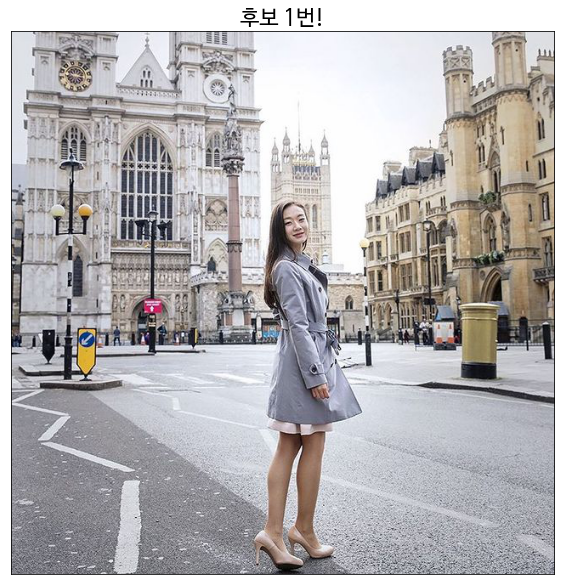

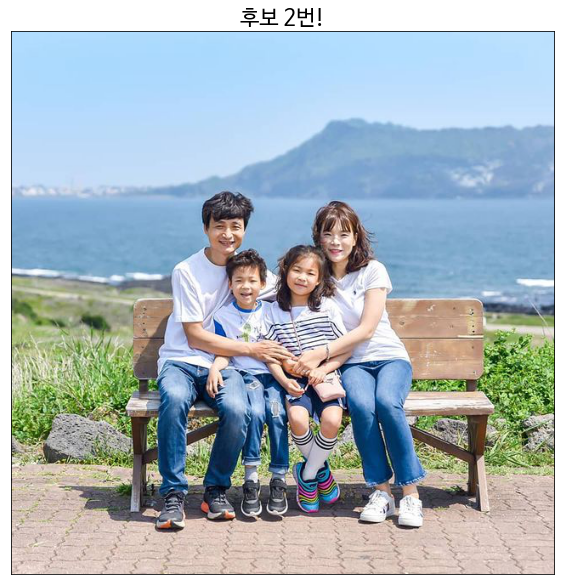

(99.98414516448975, '/content/img/1/648.jpg')

In [ ]:
image_select(test_path, VGG16_model)

In [ ]:
def image_select_two(path, model) :
    img_dict = {}
    
    for idx, image in enumerate(path) :
        img = cv2.imread(image)
        img = cv2.resize(img, (640,640))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        logits = model.predict(img)[0]
        logit = float(logits[0]) * 100
        img_dict[image] = logit

    max_value = []
    for key in img_dict.values() :
        max_value.append(key)
        max_value.sort(reverse=True)
        print('Wow!  결승 후보작!')
    
    time.sleep(3)
    n=0
    for i, v in img_dict.items() : 
        if v == max_value[0] :
            a = v
            b = i
            plt.figure(figsize=(10,10))
            ax = plt.subplot()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(plt.imread(i))

            plt.title('후보 1번!')
            plt.show()
            time.sleep(10)

        elif v == max_value[1]:
            plt.figure(figsize=(10,10))
            ax = plt.subplot()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.imshow(plt.imread(i))
            plt.title('후보 2번!')
            plt.show()

    # 내장함수.. 오류.. 어떻게 path를 내야할지에 대한 접근방법
    def image_select_last(a, b) :     
        plt.figure(figsize=(10,10))
        ax = plt.subplot()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(plt.imread(i))
        plt.title(f'최고 금손!  점수는: {a:.1f}%')
        plt.show()

    return 